In [116]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

In [43]:
x = pd.read_csv('data/x_train.csv.gz', delimiter=';')
y = np.ravel(pd.read_csv('data/y_train.csv.gz', names=['target']))
test = pd.read_csv('data/x_test.csv.gz', delimiter=';')

In [44]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [45]:
def score(clf, x, y):
    scores_auc = cross_val_score(clf, x, y, cv=5, scoring='roc_auc')
    scores_mae = cross_val_score(clf, x, y, cv=5, scoring='neg_mean_absolute_error')
    print("MAE: {} (+/- {})".format(-100*scores_mae.mean(), scores_mae.std() * 2))
    print("AUC: {} (+/- {})".format(scores_auc.mean(), scores_auc.std() * 2))

In [46]:
score(SGDClassifier(random_state=42), x_scaled, y)

MAE: 17.948470386283088 (+/- 0.020004054334218382)
AUC: 0.8586387393867305 (+/- 0.03424434468207522)


In [91]:
score(LogisticRegression(random_state=42), x_scaled, y)

MAE: 17.727081969702144 (+/- 0.009149792555057441)
AUC: 0.8737677011517473 (+/- 0.013770296640140896)


In [53]:
score(RandomForestClassifier(random_state=42, n_estimators=100), x_scaled, y)

MAE: 17.869422916770908 (+/- 0.011670959862864759)
AUC: 0.8659720344612796 (+/- 0.013596774142992563)


In [75]:
transform = PolynomialFeatures(2)
scaler = StandardScaler()
x_poly = transform.fit_transform(x)
x_poly_scaled = scaler.fit_transform(x_poly)

In [67]:
score(LogisticRegressionCV(random_state=42), x_poly_scaled, y)

MAE: 17.15368981279229 (+/- 0.008893757492816436)
AUC: 0.8784556132962245 (+/- 0.012996935929303264)


In [105]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
clf = LogisticRegression(random_state=42)
search = GridSearchCV(clf,param_grid=param_grid, scoring='neg_mean_absolute_error', cv=StratifiedKFold())

In [100]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

In [106]:
search.fit(x_poly_scaled, y)
print(search.best_params_)
print(search.best_score_)

{'C': 0.05}
-0.171972003638


/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


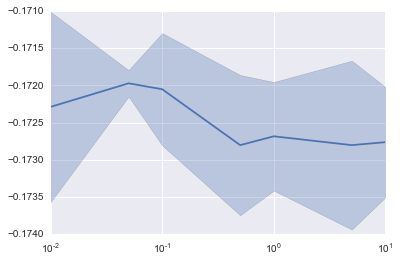

In [107]:
plot_scores(search)

In [117]:
def get_distance(fpr, tpr):
    return ((fpr) ** 2 + (tpr - 1) ** 2) ** 0.5

def get_opt_thresh(actual, predicted):
    fprs, tprs, thrs = roc_curve(actual, predicted)

    fpr_opt = None
    tpr_opt = None
    distance_opt = None
    thr_opt = None
    for i in range(len(thrs)):
        dist = get_distance(fprs[i], tprs[i])
        if (distance_opt is None) or (dist < distance_opt):
            distance_opt = dist
            fpr_opt = fprs[i]
            tpr_opt = tprs[i]
            thr_opt = thrs[i]
    
    return thr_opt

0.250655055921


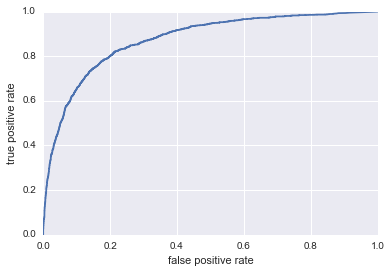

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x_poly_scaled, y)

clf = LogisticRegression(**search.best_params_)
clf.fit(x_train, y_train)
pred = clf.predict_proba(x_test)[:,1]

fpr, tpr, thr = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

opt_tresh = get_opt_thresh(y_test, pred)
print(opt_tresh)

In [109]:
transform = PolynomialFeatures(2)
scaler = StandardScaler()
test_poly = transform.fit_transform(test)
test_poly_scaled = scaler.fit_transform(test_poly)

In [120]:
pred_test = search.predict_proba(test_poly_scaled)[:,1]
pred_test_ = [1 if p > opt_tresh else 0 for p in pred_test]

In [121]:
submission = pd.DataFrame()
submission['target'] = pred_test_
submission.to_csv("submissions/3_improve_baseline.csv", index=False, header=False)

# XGB

In [123]:
import xgboost as xgb

In [126]:
xgb_param_grid = {'n_estimators': [300], 'learning_rate': [0.05, 0.03, 0.1], 'max_depth': [4,6,8,10], 'colsample_bytree': [0.4, 0.8, 1]}

In [127]:
clf_xgb = xgb.XGBClassifier()
xgb_search = GridSearchCV(clf_xgb, param_grid=xgb_param_grid, scoring='roc_auc', cv=StratifiedKFold())
xgb_search.fit(x_scaled, y)
print(xgb_search.best_params_)
print(xgb_search.best_score_)

{'learning_rate': 0.03, 'n_estimators': 300, 'max_depth': 4, 'colsample_bytree': 0.8}
0.880303195115


In [128]:
def get_and_show_tresh(clf, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    clf.fit(x_train, y_train)
    pred = clf.predict_proba(x_test)[:,1]

    fpr, tpr, thr = roc_curve(y_test, pred)
    plt.plot(fpr, tpr)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")

    opt_tresh = get_opt_thresh(y_test, pred)
    print(opt_tresh)
    return opt_tresh

0.252756


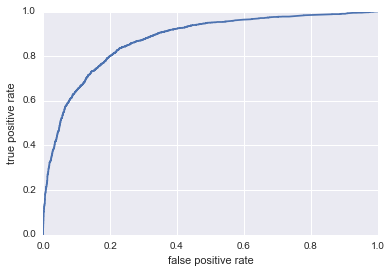

In [132]:
opt_tresh = get_and_show_tresh(xgb.XGBClassifier(**xgb_search.best_params_), x_scaled, y)

In [133]:
pred_test = search.predict_proba(test_poly_scaled)[:,1]
pred_test_ = [1 if p > opt_tresh else 0 for p in pred_test]
submission = pd.DataFrame()
submission['target'] = pred_test_
submission.to_csv("submissions/3_improve_xgb.csv", index=False, header=False)